# Introduction

This notebook generates the figure 3 for the paper `Assessing the public landscape of clinical stage pharmaceuticals through freely available online databases`

In [2]:
import pandas as pd
import itertools
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = '16'

def get_apis(df, name):
    return set(df[df.source_name==name].api_id)

def make_label(df, name):
    return name + ' (' + 'n = ' + str(df.loc[name].values[0]) + ')'

def get_overlap(df, sources, n=3):
    # get the overlap in number of drugs between any n sources
    dat = {}
    for i,source_list in enumerate(itertools.combinations(sources,n)):

        apis = [get_apis(df,l) for l in source_list] # set of apis, one for each source in source_list
        dat[source_list] = len(set.intersection(*apis))

    return pd.DataFrame(pd.Series(dat, name='num_drugs_overlap'))


def get_conn():
    '''
    Get a sqlalchemy connection engine using the read-only credentials of the live CDEK data
    '''
    
    uri = 'postgres://cdec:p3e5c85362ff4fdf7edbb6f5eccf299c48d8e2baf176bf80a3d4685e60a2deaa2@ec2-34-228-234-31.compute-1.amazonaws.com:5432/dflsafiqsli23l'
    return create_engine(uri)

In [3]:
# get number of unique APIs total in the databases of interest:
sources = ['ChEMBL','DrugBank','PubChem','nme','WITHDRAWN','repoDB','superdrug2','Drug Central']
sources_str = ', '.join("'{0}'".format(w) for w in sources)

sql = ("SELECT count(distinct(api_id)) "
       "FROM link_names_apis where source_name in "
       "(%s)" %sources_str)

num_unique_apis = pd.read_sql(sql, get_conn())
print('Total number of Active Pharmaceutical Ingredients (API) found in the public domain:')
print(num_unique_apis.iloc[0,0])


Total number of Active Pharmaceutical Ingredients (API) found in the public domain:
11763


In [4]:
# get data (api_id, source_name)
sources = ['AACT','ChEMBL','DrugBank','PubChem','nme','WITHDRAWN','repoDB','superdrug2','Drug Central']
sources_str = ', '.join("'{0}'".format(w) for w in sources)

sql = ("SELECT distinct on (api_id, source_name) api_id, source_name "
       "FROM link_names_apis where source_name in "
       "(%s)" %sources_str)

links = pd.read_sql(sql, get_conn())


In [5]:
# get data (api_id, source_api_id, api_name, source_name) - this generates the data that will be saved as a csv for transparency
sources_data = ['ChEMBL','DrugBank','PubChem','nme','WITHDRAWN','repoDB','superdrug2','Drug Central']
sources_str_data = ', '.join("'{0}'".format(w) for w in sources)

sql = ("SELECT distinct on (api_id, source_name) api_id,source_api_id, api_name, source_name "
       "FROM link_names_apis where source_name in "
       "(%s) and is_primary = 'true'" %sources_str )

data_links = pd.read_sql(sql, get_conn())
data_links.to_csv('data_links.csv')

## Number of APIs with a given source

In [8]:
# number of drugs for each source
counts = (links.groupby('source_name')
               .size()
               .reset_index(name='num_APIs')
               .set_index('source_name'))

counts.sort_values('num_APIs', ascending=False)

,num_APIs
source_name,
AACT,17074
PubChem,10024
ChEMBL,7039
DrugBank,4743
Drug Central,4609
superdrug2,3911
nme,1951
repoDB,1541
WITHDRAWN,618


## Number of drugs overlapping between any 2 sources

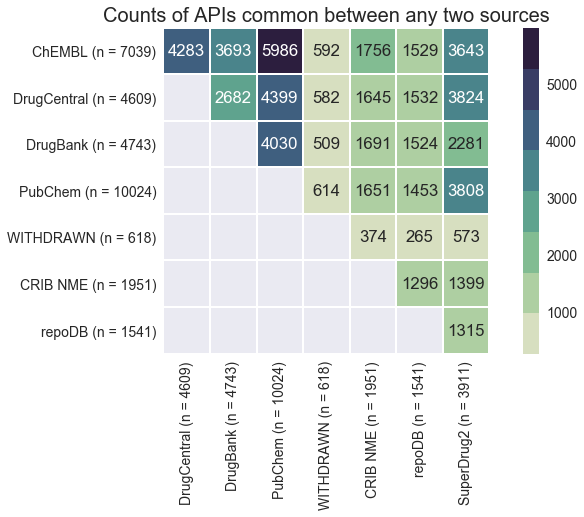

In [9]:
# get number of overlaping api_id for each source pair
cols = ['source1','source2','num_drugs_overlap']
overlap = pd.DataFrame(columns=cols)

# remove AACT for the time being
sources = sorted(list(set(sources) - set(['AACT'])))


for i,(s1,s2) in enumerate(itertools.combinations(sources,2)):
    s1_api_id = get_apis(links, s1)
    s2_api_id = get_apis(links, s2)
    
    # add total drug count to each label
    l1 = make_label(counts, s1)
    l2 = make_label(counts, s2)
    
    overlap.loc[i] = [l1, l2, len(s1_api_id & s2_api_id)]

overlap_pivot = overlap.pivot(cols[0], cols[1], cols[2]).fillna(np.nan)

overlap_pivot.columns=overlap_pivot.columns.str.replace('Drug Central','DrugCentral')
overlap_pivot.columns=overlap_pivot.columns.str.replace('nme','CRIB NME')
overlap_pivot.columns=overlap_pivot.columns.str.replace('superdrug2','SuperDrug2')

overlap_pivot.index=overlap_pivot.index.str.replace('Drug Central','DrugCentral')
overlap_pivot.index=overlap_pivot.index.str.replace('nme','CRIB NME')
overlap_pivot.index=overlap_pivot.index.str.replace('superdrug2','SuperDrug2')

# plot
sns.set(font_scale=1.4)
plt.figure(figsize=(12,6))
plt.title('Counts of APIs common between any two sources', fontsize=20)
ax = sns.heatmap(overlap_pivot,
                 annot=True,
                 fmt=".0f",
                 cmap=sns.cubehelix_palette(8, start=.5, rot=-.75), 
                 square=True, linewidths=1)

ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('heatmap_sources.png',bbox_inches='tight')